In [3]:
from torch.nn import ReLU
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from torch.nn import ReLU
from torchvision import datasets, transforms
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix  # for evaluating results
from torchvision.utils import make_grid
import pandas as pd
import seaborn as sn

In [9]:
# <editor-fold desc="helper">


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                             'Trouser',
                             'Pullover',
                             'Dress',
                             'Coat',
                             'Sandal',
                             'Shirt',
                             'Sneaker',
                             'Bag',
                             'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
# </editor-fold>

## 1-Device definition

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2- Data

In [7]:
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Download and load the training data
train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...


..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


## 3- Model definition

In [8]:
class Net_Udacity(nn.Module):
    def __init__(self,in_size=784,out_size=10,hid_size=[128,64]):
        super().__init__()
        self.fc1 = nn.Linear(in_size, hid_size[0])
        self.fc2 = nn.Linear(hid_size[0], hid_size[1])
        self.fc3 = nn.Linear(hid_size[1], out_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1) #input [.,1,28,28] will be converted to [.,728]. In case of one data [1,728]. in case of batch [64,728]
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #takes 1 channel, gives 10 channel
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #takes 10 channel, gives 20 channel
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):# x size[64,1,28,28] this is the input size [64 picture, 1 channel, 28 pixcel, 28 pixcel]
        x = self.conv1(x)#[64, 10, 24, 24] this changes channel and pixel
        x = F.max_pool2d(x, 2)#[64, 10, 12, 12] this changes pixel
        x = F.relu(x)
        x = self.conv2(x)#[64, 20, 8, 8] this changes channel and pixel
        x = self.conv2_drop(x) # this doesnt change anything
        x = F.max_pool2d(x, 2)#[64, 20, 4, 4] this changes pixels
        x = F.relu(x)
        x = x.view(-1, 320)  #[64, 320]
        x = self.fc1(x)#[64, 50]
        x = F.relu(x)
        # x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)#[64, 10]
        return F.log_softmax(x, dim=1)


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):#[64,1,28,28]
        X = F.relu(self.conv1(X)) #[64, 6, 26, 26]
        X = F.max_pool2d(X, 2, 2) #[64, 6, 13, 13]
        X = F.relu(self.conv2(X)) #[64, 16, 11, 11]
        X = F.max_pool2d(X, 2, 2) #[64, 16, 5, 5]
        X = X.view(-1, 5*5*16)#[64, 400]
        X = F.relu(self.fc1(X))#[400,120]
        X = F.relu(self.fc2(X))#[120,84]
        X = self.fc3(X)#[84,10]
        return F.log_softmax(X, dim=1)
        return X

In [12]:
model = Net_Udacity().to(device)
model = Net().to(device)
model=Classifier().to(device)
model=ConvolutionalNetwork().to(device)


## 4- Model size

In [13]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## 5- Size Analysis

In [14]:
data, targets = next(iter(train_loader))
data.size()  # # [64,1,28,28] will be converted to [64,784] in the model

torch.Size([64, 1, 28, 28])

In [15]:
model(data.to(device)).size()  # [64,10] #batch model
data[0].size()  # [1,28,28]   #one data

torch.Size([1, 28, 28])

In [16]:
data_1 = data[0].unsqueeze(0)
data_1.size()  # [1,1,28,28]

torch.Size([1, 1, 28, 28])

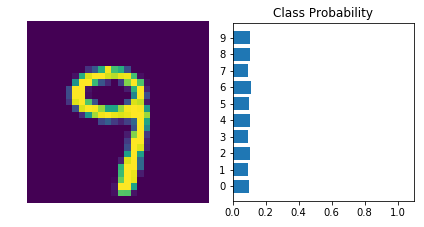

In [17]:
with torch.no_grad():
    logps = model.forward(data_1.to(device))#one model
ps = torch.exp(logps.cpu())
view_classify(data[0], ps)
# plt.figure()
# plt.imshow(data[0].reshape((28,28)), cmap="gist_yarg");
# plt.figure()
# plt.imshow(data[0].reshape((28,28)), cmap="gray");

## 6- Optimizer and Loss

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.003)
optimizer.zero_grad()
criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss() #this is used since we have multi class

## 7- Fit functions

In [20]:
def fit(model,device,data_loader,optimizer,criterion,phase='training'):
    valid_loss=0
    preds=[]
    labels=[]

    for i,(data, targets) in enumerate(data_loader):

        output = model.forward(data.to(device))
        loss = criterion(output, targets.to(device))
        valid_loss += loss.item()
        preds.extend([i.argmax().item() for i in output])
        labels.extend([t.item() for t in targets])
        _,acc=give_accuracy(preds,labels)
        if phase == 'training':
            loss.backward() #calculates gradients
            optimizer.step() #updates weights using gradients
            optimizer.zero_grad() #zeros gradients for next loop
            if i % 100 == 0:
                print(f'epoch: {e:2} batch :{i:2}  loss: {loss.item():10.8f} accuracy: {acc:2}')



    return valid_loss,preds,labels,optimizer
def give_accuracy(preds,labels):
    correct_preds=len([i for i, j in zip(preds, labels) if i == j])
    all_labels=len(labels)
    return correct_preds, 100 * correct_preds / all_labels

def wrong_preds(preds,labels):
    return [k for k,(i, j) in enumerate(zip(preds, labels)) if i != j]

def report(running_loss,preds,labels,phase="training"):
    print(f"Training loss: {running_loss}")
    all_labels=len(labels)
    correct_preds,accuracy=give_accuracy(preds,labels)
    print(f'{correct_preds} out of {all_labels} = {accuracy:.2f}% correct')

    print(f'\n')
    print(np.arange(10).reshape(1,10))
    print()
    print(confusion_matrix(preds, labels))

    print(f'\n')
    if phase=="validation":
        arr = confusion_matrix(preds, labels)
        class_names=np.arange(10).reshape(1,10)
        c_names=[str (i) for i in class_names[0]]
        df_cm = pd.DataFrame(arr, c_names, c_names)
        plt.figure(figsize = (9,6))
        sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        plt.show();

    return accuracy

## 8- Training

epoch:  0 batch : 0  loss: 0.03282929 accuracy: 98.4375
epoch:  0 batch :100  loss: 0.01771923 accuracy: 98.9944306930693
epoch:  0 batch :200  loss: 0.00480307 accuracy: 98.8106343283582
epoch:  0 batch :300  loss: 0.06619927 accuracy: 98.81644518272425
epoch:  0 batch :400  loss: 0.04742783 accuracy: 98.7803927680798
epoch:  0 batch :500  loss: 0.05042199 accuracy: 98.71195109780439
epoch:  0 batch :600  loss: 0.01928394 accuracy: 98.681884359401
epoch:  0 batch :700  loss: 0.00162806 accuracy: 98.6537089871612
epoch:  0 batch :800  loss: 0.09445805 accuracy: 98.67743445692884
epoch:  0 batch :900  loss: 0.01279614 accuracy: 98.65600721420644
-----------------------------------epoch:0
Training loss: 40.306138571264455
59187 out of 60000 = 98.64% correct


[[0 1 2 3 4 5 6 7 8 9]]

[[5870    1    7    2    2    8   14    1   10   14]
 [   3 6692    6    2    7    1    7   14    9    4]
 [   6    7 5890   27    1    1    2   26   15    2]
 [   1    3   12 6034    0   22    2    8   19  

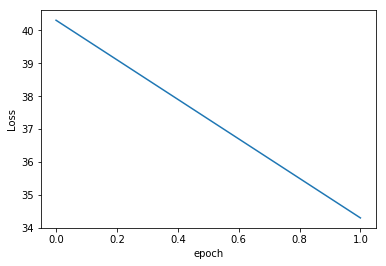

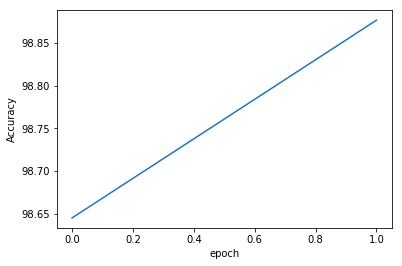

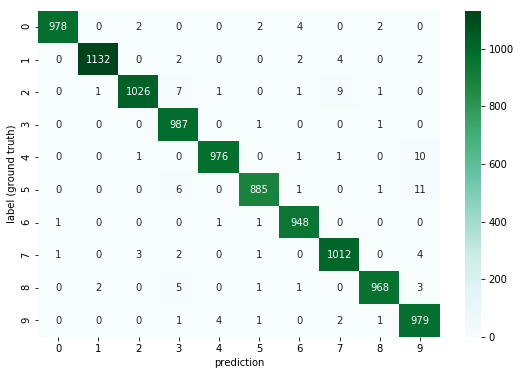

some misclassifications:
Index: [ 18  92 245 247 445 449 659 740 882 938 947]
Label: [3, 9, 3, 4, 6, 3, 2, 4, 9, 3, 8]
Guess: [8, 4, 1, 2, 0, 5, 7, 9, 4, 5, 9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


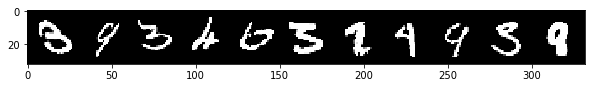

In [22]:
epochs = 2
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
losses = []
accuracy = []
for e in range(epochs):
    running_loss,preds,labels,optimizer=fit(model,device,train_loader,optimizer,criterion,phase='training')
    losses.append(running_loss)
    print("-----------------------------------epoch:"+str(e))
    acc=report(running_loss,preds,labels)
    accuracy.append(acc)
else:
    print("===================================Test")
    end.record()
    torch.cuda.synchronize()
    print("elapesed time: {} Min".format(start.elapsed_time(end) / 60000))
    plt.figure()
    plt.plot(range(epochs), losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');
    plt.figure()
    plt.plot(range(epochs), accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch');
    # ------------------------------------------------------------6-Validate the model
    with torch.no_grad():
        valid_loss,preds,labels,_=fit(model,device,test_loader,optimizer,criterion,phase="validation")
    report(valid_loss,preds,labels,phase="validation")
    #**************************************some wrong labels
    test_load_all = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)#need to reload without shuffle

    for X_test, labels in test_load_all:
        output = model.forward(X_test.to(device))
        preds=[i.argmax().item() for i in output]
        pass

    minties=wrong_preds(preds,labels)
    minties_10=minties[:10]
    len(minties)
    r = 12   # row size
    row = iter(np.array_split(minties,len(minties)//r+1))

    #--------rerun this to generate new
    print("some misclassifications:")
    nextrow = next(row)
    print("Index:", nextrow)
    print("Label:",[j.item() for i,j in enumerate(labels) if i in torch.tensor(nextrow).numpy()])
    print("Guess:", [j for i,j in enumerate(preds) if i in torch.tensor(nextrow).numpy()])

    images = X_test.index_select(0,torch.tensor(nextrow).to(dtype=torch.int64))
    im = make_grid(images, nrow=r)
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
